In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib notebook


actually this looks like a non-strict saddle since f'' is 0 at the saddle

### Run methods

<IPython.core.display.Javascript object>


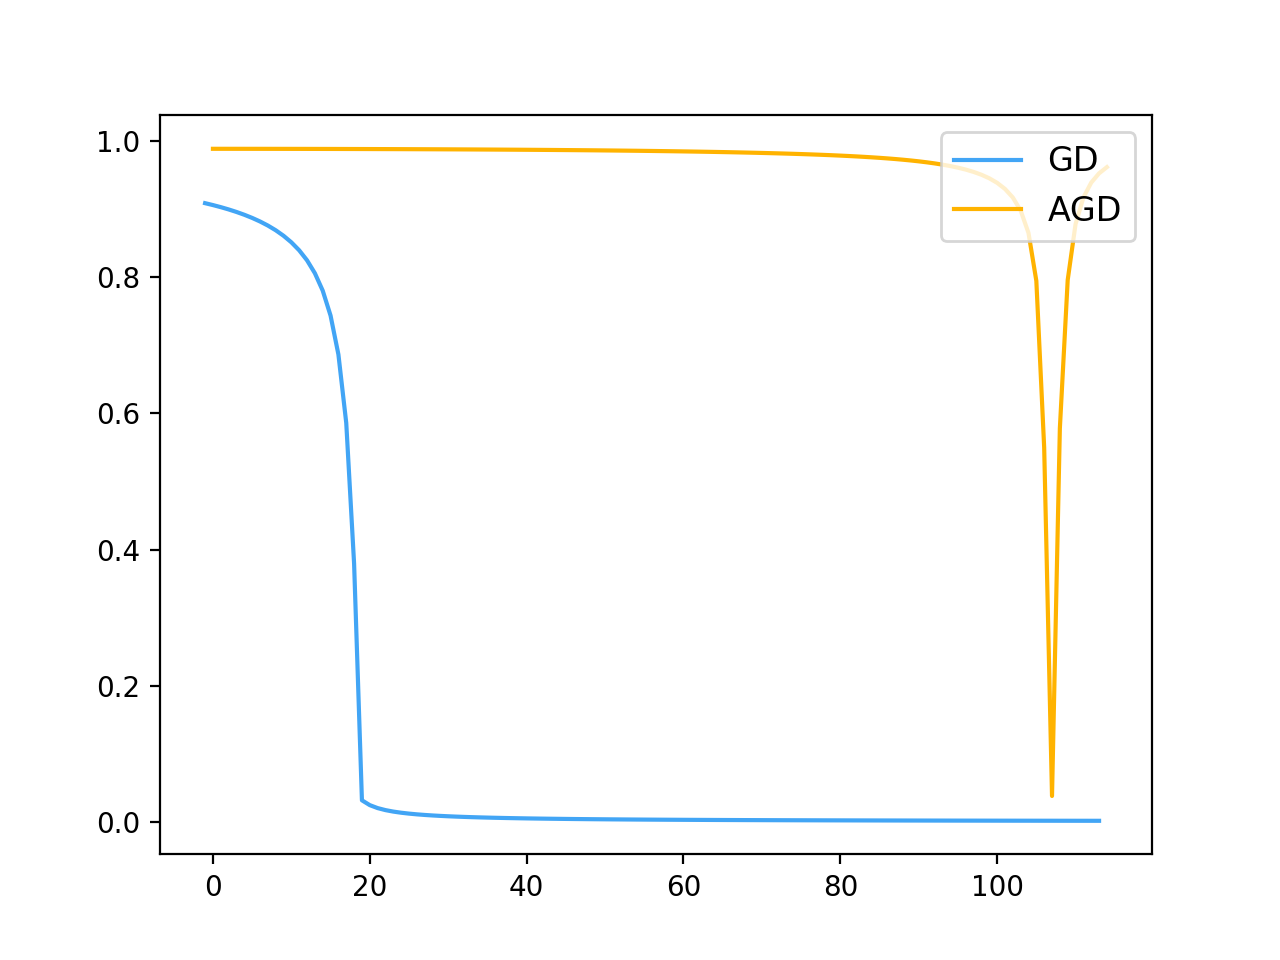

<IPython.core.display.Javascript object>


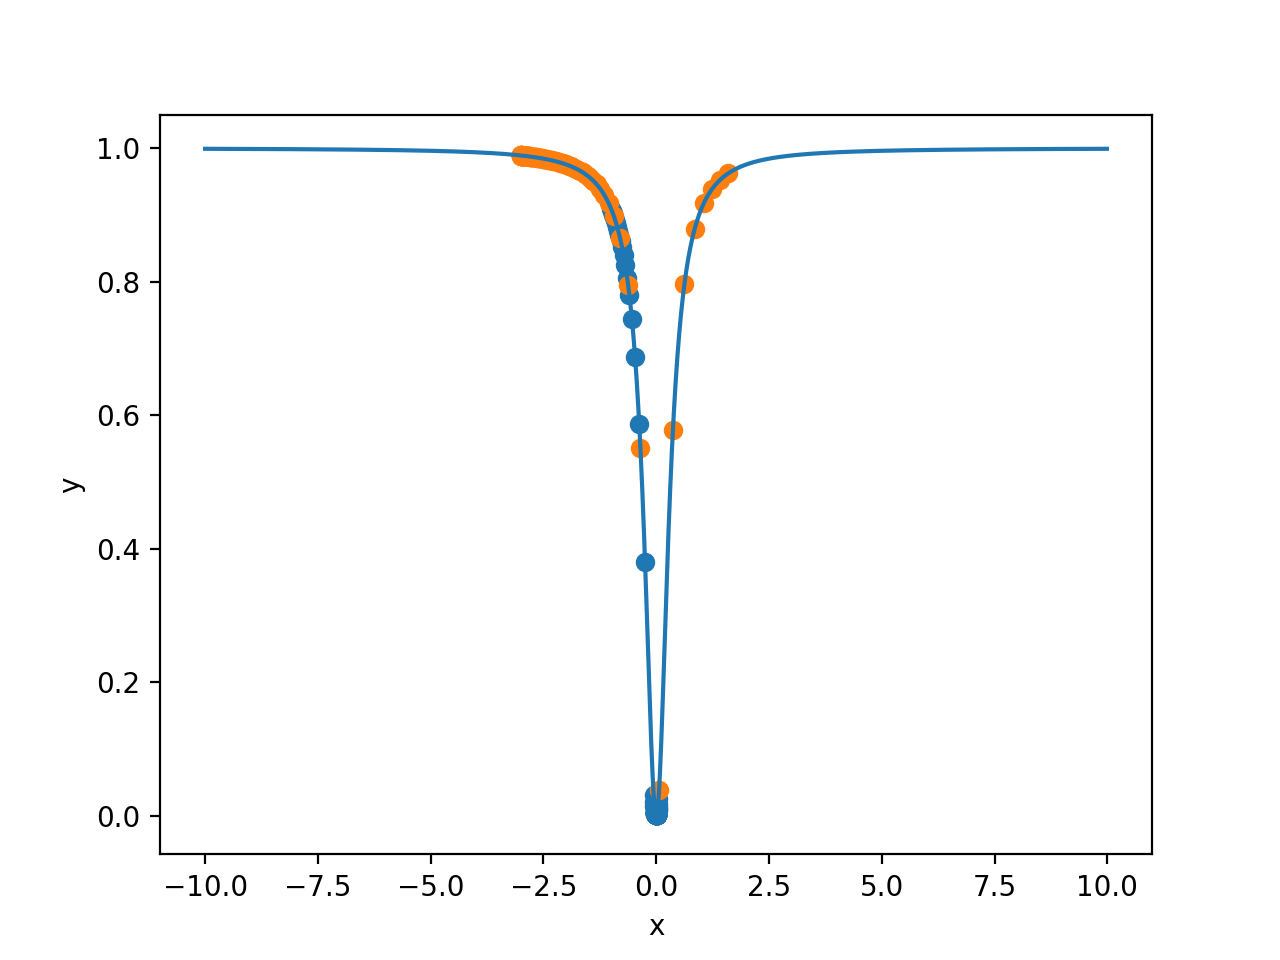

In [95]:
# no_of_runs=1
iterations=115
accuracy=1e-10
step_size=0.1
no_of_runs=1

global loss_type, log_loss
log_loss=False
loss_type='1d'
list_loss = []
list_x = []
list_methods = []
list_steps = []
#plot limits
limits=np.array((-10,10))

GD=True
PGD=False
AGD=True
PAGD=False
Momentum=False



w_0=-3


if GD:

    loss_collector=[]
    x_collector=[]
    for k in range(no_of_runs):
        (GD_steps,_x,_loss)= Gradient_Descent(-1,iterations,step_size,accuracy)
        loss_collector.append(_loss)
        x_collector.append(_x)
    GD_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    GD_x =[float(sum(col))/len(col) for col in zip(*x_collector)]   
    
    list_loss.append(GD_loss)
    list_x.append(GD_x)
    list_methods.append('GD')
    list_steps.append(GD_steps)
 
if AGD:

    loss_collector=[]
    x_collector=[]
    for k in range(no_of_runs):
        (AGD_steps,_x,_loss)= Accelerated_Gradient_Descent(w_0,iterations,step_size,accuracy)
        loss_collector.append(_loss)
        x_collector.append(_x)
    AGD_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    AGD_x =[float(sum(col))/len(col) for col in zip(*x_collector)]   
    
    list_loss.append(AGD_loss)
    list_x.append(AGD_x)
    list_methods.append('AGD')
    list_steps.append(AGD_steps)


    
make_plot(list_loss,list_x,list_methods,list_steps,limits)


### some necessary functions:

In [55]:
 def compute_loss(w):
        
    if loss_type=='1d':
        a=0.1
        loss= y=(w**2)/(w**2+a)      
    else:
        raise ValueError("Unknown losstype!")
    
    return loss

def compute_gradients(w):
# forward pass

    if loss_type=='1d':
        a=0.1
        grad= (2*a*w)/(a + w**2)**2
    else:
        raise ValueError("Unknown losstype!")
        
    return grad



def make_plot(list_loss,list_x,list_methods,list_steps,limits):
    colors = ['#42A5F5', '#FFB300', '#BA68C8','#7CB342']
    
    a=0.1

    s=0.01
    t1 = np.arange(limits[0], limits[1], s)

    if log_loss:
        #overall min value
        min_value=1000
        for k in range(len(list_loss)):
            min_value = min(list_loss[k]) if (min(list_loss[k])<=min_value) else min_value
        #subtract min value from all values and add epsilon
        eps = min_value*1e-6
        for k in range(len(list_loss)):
            list_loss[k]= [i - min_value+eps  for i in list_loss[k]]

    #2. Plot performance over time/steps
    plt.figure(1)

    plt.plot()
    for i in range(len(list_loss)):
        plt.plot(list_x[i], list_loss[i],color= colors[i])
    plt.legend(list_methods,fontsize=12, loc=1)
      
    if log_loss:
        plt.yscale('log')
    else: 
        plt.yscale('linear')
    #3 .Plot Error Surface
    plt.figure(2)
    plt.plot(t1, (t1**2)/(t1**2+a))

    # Show iterates
    for i in range(len(list_loss)):
        plt.scatter(list_steps[i],list_loss[i])

        

    plt.xlabel('x')
    plt.ylabel('y')



### Gradient Descent

In [53]:
# Run GD (simultaneously)
def Gradient_Descent(w,iterations,step_size,accuracy):
    iterates=[]
    loss=[]
    x=[]
    for k in range(iterations): 
        #safe information
        iterates.append(w)
        x.append(k-1)
        loss.append(compute_loss(w))
        
        #take step
        grad=compute_gradients(w)  
        w=w-step_size*grad


    return(iterates,x,loss)

### Accelerated Gradient Descent

In [52]:
#Run AGD
def Accelerated_Gradient_Descent(w,iterations,step_size, accuracy):
    iterates=[]
    loss=[]
    x=[]
    w_old=w

    for k in range(1,iterations+1): 
        iterates.append(w)
        x.append(k-1)
        loss.append(compute_loss(w))
        
        #compute y_(k)
        y=w+(k-1)/(k+2)*(w-w_old)
        if loss_type=='tube':
            if y[1]<0:
                y[1]=-y[1]
        #store x_(k-1)
        w_old=w
        #compute gradients
        grad=compute_gradients(y)
        w=y-step_size*grad
        if loss_type=='tube': #if no mirroring trick is used in gradients. apply here!
            if w[1]<0:
                print(' neg x_2')
            #    w[1]=-w[1]


    return(iterates,x,loss)

In [4]:
def Perturbed_Accelerated_Gradient_Descent(w,iterations,step_size,accuracy,t_thres, g_thres,f_thres,radius):
    iterates=[]
    loss=[]
    x=[]
    w_old=w
  
    t_noise=-t_thres-1
    eta=step_size
    
    for k in range(iterations): 
        #safe information
        iterates.append(w)
        x.append(k-1)
        loss_w=compute_loss(w)
        loss.append(loss_w)
        
        #compute y_(k)
        y=w+(k-1)/(k+2)*(w-w_old)
        if loss_type=='tube':
            if y[1]<0:
                y[1]=-y[1]
        #store x_(k-1)
        w_old=w
        #compute gradients
        grad=compute_gradients(y) 
        
        #Should we perturb the extrapolation point or rather x_k+1.. My guess is the extrapolation point.
        
        if np.linalg.norm(grad)<g_thres:
            #Sample 1 point uniformly form ball with radius r 
            p=radius*np.ones(1)
            while np.linalg.norm(p)>radius:
                p = radius*np.random.normal(size=(1, 1))[0]
            _y=y
            t_noise=k
            y=_y+p
            grad=compute_gradients(y)  
            
        w=y-step_size*grad
        
        if loss_type=='tube':
            if w[1]<0:
                print(' neg x_2')
                #w[1]=-w[1]
    
        if np.linalg.norm(grad)<accuracy:
            break

    return(iterates,x,loss)

### Momentum

In [3]:
#Run Momentum
def Heavy_Ball(w,iterations,step_size, accuracy):
    iterates=[]
    loss=[]
    x=[]
    w_old=w

    for k in range(1,iterations+1): 
        iterates.append(w)
        x.append(k-1)
        loss.append(compute_loss(w))
        
        #compute y_(k)
        y=w+(k-1)/(k+2)*(w-w_old)
        #store x_(k-1)
        w_old=w
        #compute gradients
        grad=compute_gradients(w)
        w=y-step_size*grad
 
        if np.linalg.norm(grad)<accuracy:
            break

    return(iterates,x,loss)

### Pertubed Gradient Descent

In [2]:
# Run GD (simultaneously)
def Pertubed_Gradient_Descent(w,iterations,step_size,accuracy,t_thres, g_thres,f_thres,radius):
    iterates=[]
    loss=[]
    x=[]
  
    t_noise=-t_thres-1
    eta=step_size
    
    for t in range(iterations): 
        #safe information
        iterates.append(w)
        x.append(t-1)
        loss_w=compute_loss(w)
        loss.append(loss_w)
        
        grad=compute_gradients(w)  
        
        if np.linalg.norm(grad)<g_thres:
            #Sample 1 point uniformly form ball with radius r 
            p=radius*np.ones(1)
            while np.linalg.norm(p)>radius:
                p = radius*np.random.normal(size=(1, 1))[0]
            _w=w
            t_noise=t
            w=_w+p
            grad=compute_gradients(w)              
            
        #if t-t_noise==t_thres and loss_w-compute_loss(_w)>-f_thres: #stop pertubing around minimizers
        #    iterates[-1]=_w
        #    loss[-1]=compute_loss(_w)
        #    break
        
        w=w-eta*grad
        if np.linalg.norm(grad)<accuracy:
            break

    return(iterates,x,loss)